In [9]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
import plotly.express as px
import math
import scipy.linalg as la
from scipy.integrate import quad

In [10]:
def kl_divergence(p, q):
    return (sum(p[i] * math.log2(p[i]/q[i]) for i in range(len(p))))

In [27]:
index = 0
p_mat = [x for x in np.arange(0,1,.05)]
kl_div = np.zeros(len(p_mat))
tvd = np.zeros(len([x for x in np.arange(0,1,.05)]))
for p_ in p_mat:
    p = [np.real(density_par(num, p_,2000)) for num in np.arange(-15,15,.1)]
    p_norm = [np.real(density_par(num, p_, 2000))/np.sum(p) for num in np.arange(-15,15,.1)]
    q = [pdf_cauchy(num) for num in np.arange(-15,15,.1)]
    q_norm = [pdf_cauchy(num)/np.sum(q) for num in np.arange(-15,15,.1)]
    r = [np.real(density_par_simplex(num, p_, 2000)) for num in np.arange(-15,15,.1)]
    r_norm = [np.real(density_par_simplex(num, p_, 2000))/np.sum(p) for num in np.arange(-15,15,.1)]
    kl_div[index] = kl_divergence(p_norm,q_norm)
    tvd[index] = (1/2)*la.norm(np.array(p_norm)-np.array(q_norm),1) 
    tvd2[index] = (1/2)*la.norm(np.array(q_norm)-np.array(r_norm),1) 
    index += 1

ValueError: x and y must have same first dimension, but have shapes (20,) and (21,)

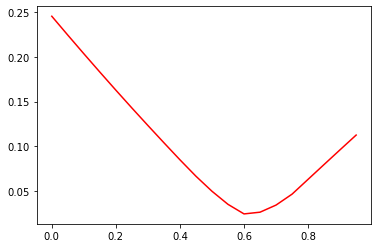

In [28]:
plt.plot(p_mat, tvd, 'r', label="TVD")
plt.plot(p_mat, tvd2, 'g', label="TVD2")
plt.xticks(np.arange(0.05, 1, .1))
plt.xlabel("p")
plt.legend()
plt.show()

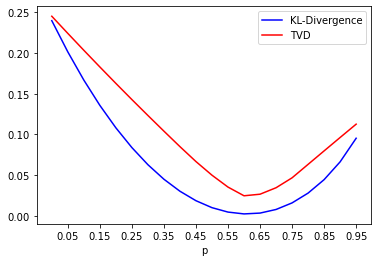

In [29]:
plt.plot(p_mat, kl_div, 'b', label="KL-Divergence")
plt.plot(p_mat, tvd, 'r', label="TVD")
plt.xticks(np.arange(0.05, 1, .1))
plt.xlabel("p")
plt.legend()
plt.show()

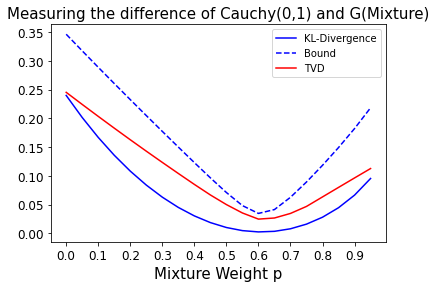

In [34]:
plt.plot(p_mat, kl_div, 'b', label="KL-Divergence")
plt.plot(p_mat, np.sqrt((1/2)*kl_div), 'b--', label="Bound")
plt.plot(p_mat, tvd, 'r', label="TVD")
plt.xticks(np.arange(0, 1, .1))
plt.title("Measuring the difference of Cauchy(0,1) and G(Mixture)", fontsize=15)
plt.xlabel("Mixture Weight p", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

In [ ]:
plt.plot([i for i in np.arange(-15,15,.1)], [np.real(density(num, p_)) for num in np.arange(-15,15,.1)])
plt.plot([i for i in np.arange(-15,15,.1)], [pdf_cauchy(num) for num in np.arange(-15,15,.1)])
plt.xlim(-15,15)
plt.ylim(0,.5)
plt.show() 

In [ ]:
kl_divergence(p,q)

In [2]:
def ell_1(n):
    U = np.random.uniform(0,1,n)
    tmp = np.array([0,1])
    Final = np.zeros(n)
    U = np.hstack((U,tmp))
    U = np.sort(U)
    for i in range(1,n+1):
        Final[i-1] = U[i] - U[i-1]
    Final = np.reshape(Final, (n,1))
    for j in range(n):
        binom = np.random.binomial(1,.5)
        if(binom == 1):
            Final[j] = Final[j]*(-1)
    return Final


def obtain_samples_lp(samples, n, p_):
    S = np.zeros((n, 1))
    for i in range(samples):
        choice = np.random.choice(2, 1, p=[p_, 1-p_])
        if(choice == 0):
            S = np.hstack((S, ell_1(n)))
        if(choice == 1):
            S = np.hstack((S,np.random.standard_cauchy((n,1))))
            #S = np.hstack((S, np.random.pareto(3,(n,1))))
    S = np.delete(S, 0,1)
    return S

In [3]:
def simplex(n):
    U = np.random.uniform(0,1,n)
    tmp = np.array([0,1])
    Final = np.zeros(n)
    U = np.hstack((U,tmp))
    U = np.sort(U)
    for i in range(1,n+1):
        Final[i-1] = U[i] - U[i-1]
    Final = np.reshape(Final, (n,1))
    return Final

In [35]:
def obtain_samples_simplex(samples, n, p_):
    S = np.zeros((n, 1))
    for i in range(samples):
        choice = np.random.choice(2, 1, p=[p_, 1-p_])
        if(choice == 0):
            S = np.hstack((S, simplex(n)))
        if(choice == 1):
            S = np.hstack((S,np.random.standard_cauchy((n,1))))
            #S = np.hstack((S, np.random.pareto(3,(n,1))))
    S = np.delete(S, 0,1)
    mean = np.mean(S)
    S = S - mean
    return S, mean
def support(X, val, q): # Set q to be the qth quantile
    return np.quantile((X.T).dot(val), q)

def compute_fb(X, q, n):
    polar_body = np.ones((n,0))
    for i in range(X.shape[1]):
        if support(X, X[:,i] / la.norm(X[:,i]), q) > np.dot(X[:,i], X[:,i]/la.norm(X[:,i])): 
            polar_body = np.hstack((polar_body, np.array(X[:,i]).reshape(n,1)))
    return polar_body

In [ ]:
samples = 15000
n = 10
S = np.zeros((n, 1))
percent = 1
fb = True
S, mean = obtain_samples_simplex(samples, n, percent)
S_1 = obtain_samples_lp(samples, n, percent)
sns.displot(S[0, :] + mean, kind='hist', stat='density', legend="Empirical");
sns.displot(S[0, :] + mean, kind="kde")
sns.displot(S_1[0, :], kind='hist', stat='density', legend="Empirical");
plt.xlim(-2,2)
plt.ylim(0,4)
V = np.hstack((np.zeros((n,1)),np.eye(n,n))) - mean
A = np.random.normal(0,1,(n,n))
sqrt = np.sqrt(np.sum(A**2, axis = 0))
A = A  / (np.tile(sqrt,(n,1)))

#A = np.array([[1,0],[0,1]])
X = A@S
V = A@V
if fb:
    X = compute_fb(X,.95,n)
    num_of_samples_left =  samples - X.shape[1]
sns.displot(X[0, :], kind='hist', stat='density', legend="Empirical");
plt.xlim(-3,3)
plt.ylim(0,4)
X = np.vstack([X, np.ones((1,X.shape[1]))])

T = np.random.gamma(X.shape[0], 1, (1,X.shape[1]))
Q = X * np.tile(T,(X.shape[0],1))


sns.displot(Q[0, :], kind='hist', stat='density', legend="Empirical");
plt.xlim(-15,15)
plt.ylim(0,1)

In [44]:
def density(z, p):
    if(z > 0):
        left = (np.exp(-z)*p)/2
        middle = (np.exp((-z)/2000)*(p-1)*(2000+z))/(4000*np.pi)
        right = (((np.exp(-1j*z))*(p-1)*(z*z))*(((np.exp(2j*z))*sp.expi(((-1/2000)-1j)*z))+sp.expi(((-1/2000)+1j)*z)-((2*np.exp(1j*z))*(sp.expn(1,z)+sp.expi(-z)+np.pi*np.sin(z)))))/(4*np.pi)
        return left-middle-right
    else:
        z = -z
        left = (np.exp(-z)*p)/2
        middle = (np.exp((-z)/2000)*(p-1)*(2000+z))/(4000*np.pi)
        right = (((np.exp(-1j*z))*(p-1)*(z*z))*(((np.exp(2j*z))*sp.expi(((-1/2000)-1j)*z))+sp.expi(((-1/2000)+1j)*z)-((2*np.exp(1j*z))*(sp.expn(1,z)+sp.expi(-z)+np.pi*np.sin(z)))))/(4*np.pi)
        return left-middle-right
def density_par(y, p, k):
    if(y > 0):
        left = np.exp(-y)*p/2
        middle = ((1-p)*(((y*y)*((np.exp(-y/k)*(k+y))/(k*y*y)
                                              +((1/2)*(sp.expi(-y/k)
                                                       +((np.exp(1j*y))*(1j*np.pi+sp.expi(((-1/k)-1j)*y)))))
                                              +((np.exp(-1j*y)/2)*(-1j*np.pi-(np.exp(1j*y)*sp.expi(-y/k))
                                                                       +sp.expi(((-1/k)+1j)*y)))
                                              -sp.gammaincc(0,y/k)))/(2*np.pi)))

        return (left+middle)
    else:
        y = -y
        left = np.exp(-y)*p/2
        middle = ((1-p)*(((y*y)*((np.exp(-y/k)*(k+y))/(k*y*y)
                                              +((1/2)*(sp.expi(-y/k)
                                                       +((np.exp(1j*y))*(1j*np.pi+sp.expi(((-1/k)-1j)*y)))))
                                              +((np.exp(-1j*y)/2)*(-1j*np.pi-(np.exp(1j*y)*sp.expi(-y/k))
                                                                       +sp.expi(((-1/k)+1j)*y)))
                                              -sp.gammaincc(0,y/k)))/(2*np.pi)))

        return (left+middle)
def cdf_cauchy(x):
    return (1/np.pi)*np.arctan(x) + .5
def pdf_cauchy(x):
    return 1/(np.pi*(1+x**2))
def pdf_normal(x):
    return np.exp(-np.power(x,2)/2)/(np.sqrt(2*np.pi))
def density_par_simplex(y, p, k):
    if(y > 0):
        left = np.exp(-y)*p
        middle = 2*((1-p)*(((y*y)*((np.exp(-y/k)*(k+y))/(k*y*y)
                                              +((1/2)*(sp.expi(-y/k)
                                                       +((np.exp(1j*y))*(1j*np.pi+sp.expi(((-1/k)-1j)*y)))))
                                              +((np.exp(-1j*y)/2)*(-1j*np.pi-(np.exp(1j*y)*sp.expi(-y/k))
                                                                       +sp.expi(((-1/k)+1j)*y)))
                                              -sp.gammaincc(0,y/k)))/(2*np.pi)))

        return (left+middle)
    else:
        y = -y
        middle = ((1-p)*(((y*y)*((np.exp(-y/k)*(k+y))/(k*y*y)
                                              +((1/2)*(sp.expi(-y/k)
                                                       +((np.exp(1j*y))*(1j*np.pi+sp.expi(((-1/k)-1j)*y)))))
                                              +((np.exp(-1j*y)/2)*(-1j*np.pi-(np.exp(1j*y)*sp.expi(-y/k))
                                                                       +sp.expi(((-1/k)+1j)*y)))
                                              -sp.gammaincc(0,y/k)))/(2*np.pi)))

        return middle

In [ ]:
p_ = .1
plt.plot([i for i in np.arange(-15,15,.01)], [(1-np.abs(num)) for num in np.arange(-15,15,.01)], label="L-1")
plt.plot([i for i in np.arange(-15,15,.01)], [2*(1-num) if num >= 0 else 0 for num in np.arange(-15,15,.01)], label="Simplex")
plt.xlim(-1,1)
plt.ylim(0,)
plt.legend()
plt.show() 

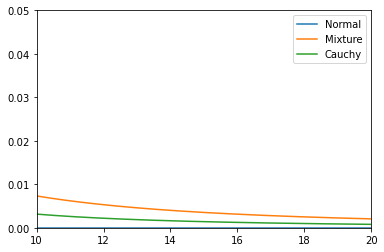

In [57]:
p_ = .1
plt.plot([i for i in np.arange(-15,20,.01)], [np.real(pdf_normal(num)) for num in np.arange(-15,20,.01)], label="Normal")
plt.plot([i for i in np.arange(-15,20,.01)], [np.real(density_par(num, p_,20000)) for num in np.arange(-15,20,.01)], label="Mixture")
plt.plot([i for i in np.arange(-15,20,.01)], [np.real(pdf_cauchy(num)) for num in np.arange(-15,20,.01)], label="Cauchy")
plt.xlim(10,20)
plt.ylim(0,.05)
plt.legend()
plt.show() 

In [ ]:
limit = 200
resarr = np.zeros((limit-1))
index = 0
for num in range(1,limit):
    res, err = quad(density_par, 0, num,args=(p_,20000))
    resarr[index] = res
    index += 1
    print(err)
plt.plot([i for i in range(1,limit)],resarr)
plt.plot()

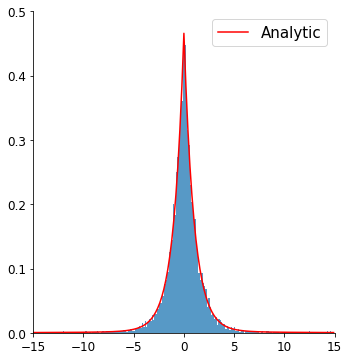

In [8]:
samples = 10000
n = 2
S = np.zeros((n, 1))
percent = .9
p_ = percent
fb = False
S = obtain_samples_lp(samples, n, percent)
A = np.array([[1,0],[0,1]])
X = A@S
if fb:
    X = compute_fb(X,.95,n)
    num_of_samples_left = samples - X.shape[1]
T = np.random.gamma(((X.shape[0]) / 1) + 1, 1, (1, X.shape[1]))
Q = X * np.tile(T ** (1 / 1), (X.shape[0], 1))

sns.displot(Q[0, :], kind='hist', stat='density', legend="Empirical");
plt.xlim(-15,15)
plt.ylim(0,.5)

plt.plot([i for i in np.arange(-15,15,.1)], [np.real(density_par(num, p_,2000)) for num in np.arange(-15,15,.1)], "r", label="Analytic")
plt.xlim(-15,15)
plt.ylim(0,.5)
plt.ylabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15);
plt.show()

In [ ]:
index = 1
for p_ in np.arange(.1,1,.1):
    plt.subplot(3,3,index).set_title("p=%d" % p_)
    samples = 3000
    n = 2
    S = np.zeros((n, 1))
    for i in range(samples):
        choice = np.random.choice(2, 1, p=[p_, 1-p_])
        if(choice == 0):
            S = np.hstack((S, ell_1(n)))
        if(choice == 1):
            S = np.hstack((S,np.random.standard_cauchy((n,1))))
    S = np.delete(S, 0,1)
    
    A = np.array([[1,0],[0,1]])
    X_ = A@S
    T = np.random.gamma(((X_.shape[0])/1)+1, 1, (1,X_.shape[1]))
    Q = X_ * np.tile(T**(1/1),(X_.shape[0],1))
    sns.displot(Q[0, :], kind='hist', stat='density');
    plt.plot([i for i in np.arange(-15,15,.1)], [np.real(density(num, p_)) for num in np.arange(-15,15,.1)])
    plt.xlim(-15,15)
    plt.ylim(0,.5)
    plt.rcParams['figure.figsize'] = [25, 20]
    print(p_)
    index += 1
plt.show()

In [ ]:
n = 2
percent = .9
samples = 5000
plots = False
fb = False
S, mean = obtain_samples_simplex(samples, n, percent)
sns.displot(S[0, :], kind='hist', stat='density', legend="Empirical");
plt.xlim(-10,10)
plt.ylim(0,1)
V = np.hstack((np.zeros((n,1)),np.eye(n,n))) - mean
A = np.random.normal(0,1,(n,n))
sqrt = np.sqrt(np.sum(A**2, axis = 0))
A = A  / (np.tile(sqrt,(n,1)))

#A = np.array([[1,0],[0,1]])
X = A@S
V = A@V
if fb:
    X = compute_fb(X,.95,n)
    num_of_samples_left =  samples - X.shape[1]
    sns.displot(X[0, :], kind='hist', stat='density', legend="Empirical");
    plt.xlim(-10,10)
    plt.ylim(0,1)
X = np.vstack([X, np.ones((1,X.shape[1]))])

T = np.random.gamma(X.shape[0], 1, (1,X.shape[1]))
Q = X * np.tile(T,(X.shape[0],1))
sns.displot(Q[0, :], kind='hist', stat='density', legend="Empirical");
plt.xlim(-10,10)
plt.ylim(0,1)
